# LaneLines by Manuel Quinteiro

## Importing libreries


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import sys
import os
import math
%matplotlib inline
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg']

## Helper functions 

In [2]:
def slopeLine(line):
    # function to calculate the slope of lines
    start = np.array([line[0], line[1]])
    end = np.array([line[2], line[3]])

    if abs(start[0] - end[0]) < sys.float_info.epsilon:
        return sys.float_info.max
    return (start[1] - end[1]) / (start[0] - end[0])


def intersectionPoint(line1, line2):
    # function to calculate the intersection between two lines
    s1 = np.array([line1[0], line1[1]])
    e1 = np.array([line1[2], line1[3]])
    s2 = np.array([line2[0], line2[1]])
    e2 = np.array([line2[2], line2[3]])

    slope1 = (s1[1] - e1[1]) / (s1[0] - e1[0])
    slope2 = (s2[1] - e2[1]) / (s2[0] - e2[0])
    b1 = s1[1] - (slope1 * s1[0])
    b2 = s2[1] - (slope2 * s2[0])

    if abs(slope1 - slope2) < sys.float_info.epsilon:
        return False

    x = (b2 - b1) / (slope1 - slope2)
    y = slope1 * x + b1
    return (x, y)


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

** drawConsolidateLine **is a function to represent a group of lines (normaly left group or right group) and transform to just one.
To achieve it takes the mean of slopes the maximun y (nimimun considering 0 in the top left corner)

In [3]:
def drawConsolidateLine(img, lines, color=[0, 255, 0]):
    x0s = []
    slopes = []
    minY = img.shape[0]

    for [line] in lines:
        if line[1] < minY:
            minY = line[1]
        if line[3] < minY:
            minY = line[3]
        slopes.append(slopeLine(line))
        x0s.append(intersectionPoint(line, [0, img.shape[0], 100, img.shape[0]])[0])
    x0 = sum(x0s) / len(x0s)
    s = sum(slopes) / len(slopes)
    b = img.shape[0] - 1 - x0 * s
    x1 = (minY - b) / s
    cv2.line(img, (int(x0), img.shape[0] - 1), (int(x1), minY), color, 8)
    [int(x0), img.shape[0] - 1, int(x1), minY]

More helper functions

In [4]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

Draw lines take the result of hough lines algorithm and discart all the lines with low slope. after that separe the lines in two groups right and left and join with **drawConsolidateLine** if one frame fails it use the last lines untir that line becomes to old. Direfent colors for diferent situations.

In [5]:
def draw_lines(img, lines, color=[255, 0, 0], cutingLine=450, thickness=2):
    # global variables for memory proposes
    global leftFails
    global rightFails
    global maxSlope
    global lastRightLine
    global lastLeftLine
    global lastLeftSlope
    global lastRightSlope
    global validRightSlopeCount
    global validLeftSlopeCount
    global lastLeftInt
    global lastRightInt

    # we will pay attention to the lines that cross a line in the image
    # cv2.line(img, (0, cutingLine), (image.shape[1], cutingLine), color, thickness)
    mid = image.shape[1] / 2
    left_lines = []
    right_lines = []
    if lines is None:
        return False
    for line in lines:

        for x1, y1, x2, y2 in line:
            slope = slopeLine(line[0]);
            if abs(slope) < maxSlope / 100:
                continue
            # cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], 1)
            #if (y1 < cutingLine and y2 < cutingLine):
            #    continue
            inter = intersectionPoint(line[0], [0, image.shape[0], image.shape[1], image.shape[0]])
            # inter = intersectionPoint(line[0], [0, cutingLine, image.shape[1], cutingLine])
            if (inter == False):
                continue
            # check if it is right or left
            if inter[0] < mid:
                #cv2.line(img, (x1, y1), (x2, y2), [255, 255, 0], 1)
                left_lines.append(line)
            else:
                #cv2.line(img, (x1, y1), (x2, y2), [0, 255, 255], 1)
                right_lines.append(line)

    # if we have found a image that fit all requirements we write it, if not we use the last information during
    # maxHisteresys frames

    if len(left_lines):
        lastLeftLine = drawConsolidateLine(img, left_lines, [0, 0, 255])
        if (validLeftSlopeCount < maxHisteresys):
            validLeftSlopeCount += 1
    else:
        #if we have no lane lines use old ones
        leftFails += 1
        # if validLeftSlopeCount is 0 the line is too old, descarted and marc as failure
        if (validLeftSlopeCount > 0):
            leftFails -= 1
            validLeftSlopeCount -= 1
            cv2.line(img, (lastLeftLine[0], lastLeftLine[1]), (lastLeftLine[2], lastLeftLine[3]), [255, 255, 0], 6)

    if len(right_lines):
        lastRightLine = drawConsolidateLine(img, right_lines, [0, 255,0 ])
        if (validRightSlopeCount < maxHisteresys):
            validRightSlopeCount += 1
    else:
        # if we have no lane lines use old ones
        rightFails += 1
        # if validLeftSlopeCount is 0 the line is too old, descarted and marc as failure
        if (validRightSlopeCount > 0):
            rightFails -= 1
            validRightSlopeCount -= 1
            cv2.line(img, (lastRightLine[0], lastRightLine[1]), (lastRightLine[2], lastRightLine[3]), [255, 255, 0], 6)

More aux functions provide by the template

In [6]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, linecutPos=0):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    # lines = cv2.HoughLines(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, color=[0, 0, 255], cutingLine=linecutPos, thickness=4)

    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


# new function to limit the pixels of the image. It work fine but I dont know if it is a good idea,
# could generate new edges.
def removeColors(initial_img, red_threshold, green_threshold, blue_threshold):
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    color_select = np.copy(image)
    thresholds1 = image[:, :, 0] < rgb_threshold[0]
    thresholds2 = image[:, :, 1] < rgb_threshold[1]
    thresholds3 = image[:, :, 2] < rgb_threshold[2]
    thresholds = (thresholds1 * 1 + thresholds2 * 1 + thresholds3 * 1) > 1
    color_select[thresholds] = [0, 0, 0]
    return color_select

In [7]:
def draw_lines2(img, lines, color=[255, 0, 0], cutingLine=450, thickness=2):
    #global variables for memory proposes
    global leftFails
    global rightFails
    global maxSlope
    global lastRightLine
    global lastLeftLine
    global lastLeftSlope
    global lastRightSlope
    global validRightSlopeCount
    global validLeftSlopeCount
    global lastLeftInt
    global lastRightInt

    #we will pay attention to the lines that cross a line in the image
    cv2.line(img, (0, cutingLine), (image.shape[1], cutingLine), color, thickness)
    mid=image.shape[1]/2
    left=0
    right=image.shape[1]
    rightLine=None
    leftLine=None
    if lines is None:
        return False
    for line in lines:

        for x1, y1, x2, y2 in line:
            if (y1 < cutingLine and y2 < cutingLine):
                continue
            slope = slopeLine(line[0]);
            #inter=intersectionPoint(line[0],[0,image.shape[0],image.shape[1],image.shape[0]])
            inter = intersectionPoint(line[0], [0, cutingLine, image.shape[1], cutingLine])
            if(inter ==False):
                continue
            #Check if intersection is inside the line
            if(inter[1]>y1 and inter[1]>y2) or (inter[1]<y1 and inter[1]<y2):
                continue
            #now we take closser line from right and closser from left
            if (inter[0]>mid and inter[0]<right):
                if abs(slope)<maxSlope/100:
                    continue
                # right
                if validRightSlopeCount and (lastRightSlope/slope < 0.92 or lastRightSlope/slope > 1.08 or abs(lastRightInt-inter[0])>15):
                    continue
                right=inter[0]
                rightLine=line[0]
            if (inter[0]<mid and inter[0]>left):
                #left
                if abs(slope)<maxSlope/100:
                    continue
                if validLeftSlopeCount and ((lastLeftSlope/slope < 0.92 ) or lastLeftSlope/slope > 1.08 or abs(lastLeftInt-inter[0])>15):
                    continue

                left=inter[0]
                leftLine=line[0]

    #if we have found a image that fit all requirements we write it, if not we use the last information during
    # maxHisteresys frames
    if leftLine is not None:
        cv2.line(img, (leftLine[0], leftLine[1]), (leftLine[2], leftLine[3]), color, thickness)
        lastLeftLine=leftLine
        lastLeftSlope=slopeLine(leftLine)
        lastLeftInt= intersectionPoint(leftLine, [0, cutingLine, image.shape[1], cutingLine])[0]
        if(validLeftSlopeCount<maxHisteresys):
            validLeftSlopeCount+=1

    else:
        leftFails+=1
        if (validLeftSlopeCount > 0):
            leftFails -= 1
            validLeftSlopeCount -= 1
            cv2.line(img, (lastLeftLine[0], lastLeftLine[1]), (lastLeftLine[2], lastLeftLine[3]), color, thickness)

    if rightLine is not None:
        cv2.line(img, (rightLine[0], rightLine[1]), (rightLine[2], rightLine[3]), color, thickness)
        lastRightLine = rightLine
        lastRightSlope = slopeLine(rightLine)
        lastRightInt = intersectionPoint(rightLine, [0, cutingLine, image.shape[1], cutingLine])[0]
        if (validRightSlopeCount < maxHisteresys):
            validRightSlopeCount += 1
    else:
        rightFails += 1
        if (validRightSlopeCount > 0):
            rightFails -= 1
            validRightSlopeCount -= 1
            cv2.line(img, (lastRightLine[0], lastRightLine[1]), (lastRightLine[2], lastRightLine[3]), color, thickness)

doImageProcess is the main transforation process as described in the report do a blur + area selected by color + canny edge detection + ROI + hough lines + line drawing. Finally it draws the result over the original image.

In [8]:

def doImageProcess(image):
    # Apply blur to original image with a small kernel.
    bluredImage = gaussian_blur(image, 3)

    # remove all pixels that is not white or yellow
    maskedImage = maskHSVYellowAndWhite(bluredImage)

    # apply canny edge algorithm to get edges
    withCanny = cv2.Canny(maskedImage, lthres, mthres)

    # reduce area of interest to a triangle
    roi = np.array([[40, withCanny.shape[0]], [withCanny.shape[1] - 40, withCanny.shape[0]],
                    [withCanny.shape[1] / 2, withCanny.shape[0] / 2 + withCanny.shape[0] /20]], np.int32)
    cropedImage = region_of_interest(withCanny, [roi])

    # finally convert the canny result to hough space and represent the lines in the output.
    hough_image = hough_lines(cropedImage, 1, 10 * np.pi / 180, thr, hough_min_length, hough_max_length,
                              int(image.shape[0] / 5) * 4)

    # merge it with original image to obtain the final result.
    final = weighted_img(hough_image, image, 0.8, 1., 0.)
    if debug==1:
        cv2.polylines(final,[roi],1,[0,255,0])
    return final, bluredImage, maskedImage, withCanny, cropedImage, hough_image


**maskHSVYellowAndWhite** Uses a HSV space for filter white and yellow, it is a more convenient methot that do over BRG space.

In [9]:
def maskHSVYellowAndWhite(orig_img):
    # Global variables for tunning process.
    global midH, midS, midV
    hsv = cv2.cvtColor(orig_img, cv2.COLOR_BGR2HSV)
    # transform from BRG to HSV

    # get yellow mask
    maskY = cv2.inRange(hsv, np.array([22 - 3, 125 - 20, 180 - 70]), np.array([22 + 3, 125 + 90, 180 + 70]))
    # get withe mask
    #maskW = cv2.inRange(hsv, np.array([midH - 10, midS - 30, midV - 25]), np.array([midH + 10, midS + 16, midV + 25]))
    maskW = cv2.inRange(hsv, np.array([0, midS - 30, midV - 25]), np.array([176, midS + 16, midV + 25]))

    # to join both mask I have to do an OR between them,
    # finally make a BRG image with 255 in all dots yellow or white
    mask = np.bitwise_or(maskW, maskY)
    mask3 = np.copy(orig_img)
    mask3[:, :, 0] = mask
    mask3[:, :, 1] = mask
    mask3[:, :, 2] = mask

    # apply mask with and bitwise operation to remove allother pixels.
    maskedImage = np.bitwise_and(mask3, orig_img)
    return maskedImage


updateGlobalVars and refreshDebugWindow are functions used during debug, the firstone chage some values with dials and the other draws 4 images as well as writes some information over screen

In [10]:
def updateGlobalVars():
    global lthres, mthres, lightLimit, maxSlope, midH, midS, midV, thr, hough_max_length, hough_min_length
    # update global var to the dials value to tune algorithm
    lthres = cv2.getTrackbarPos('lthres', 'Final')
    mthres = cv2.getTrackbarPos('mthres', 'Final')
    lightLimit = cv2.getTrackbarPos('lightLimit', 'Final')
    maxSlope = cv2.getTrackbarPos('slope', 'Final')
    midH = cv2.getTrackbarPos('H', 'Final')
    midS = cv2.getTrackbarPos('S', 'Final')
    midV = cv2.getTrackbarPos('V', 'Final')
    thr = cv2.getTrackbarPos('thr', 'Final')
    hough_min_length = cv2.getTrackbarPos('minL', 'Final')
    hough_max_length = cv2.getTrackbarPos('maxL', 'Final')


def refreshDebugWindow(image1, image2, image3, image4):
    # draw 4 images to help understand the intermedian results.
    # create image
    global leftFails, rightFails, validLeftSlopeCount, validRightSlopeCount, frames
    sc = image1.shape[1]
    sr = image1.shape[0]
    full_image = np.zeros((sr * 2, sc * 2, 3), np.uint8)
    if len(image1.shape) > 2:
        full_image[0:sr, 0:sc] = image1
    else:
        full_image[0:sr, 0:sc, 2] = image1
    if len(image2.shape) > 2:
        full_image[sr:sr + sr, 0:sc] = image2
    else:
        full_image[sr:sr + sr, 0:sc, 2] = image2
    if len(image3.shape) > 2:
        full_image[0:sr, sc:sc + sc] = image3
    else:
        full_image[0:sr, sc:sc + sc, 2] = image3
    if len(image4.shape) > 2:
        full_image[sr:sr + sr, sc:sc + sc] = final
    else:
        full_image[sr:sr + sr, sc:sc + sc, 2] = final

    # show text about how good are the results, remaining memory frames,etc
    cv2.putText(full_image, "leftFails = " + str(leftFails), (0, 120), 0, 2, [255, 0, 0], 3)
    cv2.putText(full_image, "rightFails = " + str(rightFails), (0, 160), 0, 2, [255, 0, 0], 3)
    cv2.putText(full_image, "leftHist = " + str(validLeftSlopeCount), (1000, 120), 0, 2, [255, 0, 0], 3)
    cv2.putText(full_image, "rightHist = " + str(validRightSlopeCount), (1000, 160), 0, 2, [255, 0, 0], 3)
    cv2.putText(full_image, "frames = " + str(frames), (0, 200), 0, 2, [255, 0, 0], 3)
    cv2.imshow("Final", cv2.resize(full_image, (0, 0), fx=0.5, fy=0.5))


## Main code starts here

starting with initialitation
The cv2 code will open a new window with the video. some screenshots are pasted at the end

In [11]:

def updateGlobalVars():
    global lthres, mthres, lightLimit, maxSlope, midH, midS, midV, thr, hough_max_length, hough_min_length
    # update global var to the dials value to tune algorithm
    lthres = cv2.getTrackbarPos('lthres', 'Final')
    mthres = cv2.getTrackbarPos('mthres', 'Final')
    lightLimit = cv2.getTrackbarPos('lightLimit', 'Final')
    maxSlope = cv2.getTrackbarPos('slope', 'Final')
    midH = cv2.getTrackbarPos('H', 'Final')
    midS = cv2.getTrackbarPos('S', 'Final')
    midV = cv2.getTrackbarPos('V', 'Final')
    thr = cv2.getTrackbarPos('thr', 'Final')
    hough_min_length = cv2.getTrackbarPos('minL', 'Final')
    hough_max_length = cv2.getTrackbarPos('maxL', 'Final')


def refreshDebugWindow(image1, image2, image3, image4):
    # draw 4 images to help understand the intermedian results.
    # create image
    global leftFails, rightFails, validLeftSlopeCount, validRightSlopeCount, frames
    sc = image1.shape[1]
    sr = image1.shape[0]
    full_image = np.zeros((sr * 2, sc * 2, 3), np.uint8)
    if len(image1.shape) > 2:
        full_image[0:sr, 0:sc] = image1
    else:
        full_image[0:sr, 0:sc, 2] = image1
    if len(image2.shape) > 2:
        full_image[sr:sr + sr, 0:sc] = image2
    else:
        full_image[sr:sr + sr, 0:sc, 2] = image2
    if len(image3.shape) > 2:
        full_image[0:sr, sc:sc + sc] = image3
    else:
        full_image[0:sr, sc:sc + sc, 2] = image3
    if len(image4.shape) > 2:
        full_image[sr:sr + sr, sc:sc + sc] = final
    else:
        full_image[sr:sr + sr, sc:sc + sc, 2] = final

    # show text about how good are the results, remaining memory frames,etc
    cv2.putText(full_image, "leftFails = " + str(leftFails), (0, 120), 0, 2, [255, 0, 0], 3)
    cv2.putText(full_image, "rightFails = " + str(rightFails), (0, 160), 0, 2, [255, 0, 0], 3)
    cv2.putText(full_image, "leftHist = " + str(validLeftSlopeCount), (1000, 120), 0, 2, [255, 0, 0], 3)
    cv2.putText(full_image, "rightHist = " + str(validRightSlopeCount), (1000, 160), 0, 2, [255, 0, 0], 3)
    cv2.putText(full_image, "frames = " + str(frames), (0, 200), 0, 2, [255, 0, 0], 3)
    cv2.imshow("Final", cv2.resize(full_image, (0, 0), fx=0.5, fy=0.5))


# then save them to the test_images directory.

# reading in an image
##image = cv2.imread('test_images/solidWhiteRight.jpg')
# image = cv2.imread('test_images/solidWhiteCurve.jpg')
# printing out some stats and plotting
# print('This image is:', type(image), 'with dimensions:', image.shape)
# cap = cv2.VideoCapture("test_videos/challenge.mp4")


# configuration variables
# videoName="test_videos/solidWhiteRight.mp4"
videoName = "test_videos/challenge.mp4"
videoImages = True
#videoImages = False
debug = 0
lightLimit = 221
maxSlope = 24
lthres = 0
mthres = 255
frames = 0
validSlopeCount = 0
lastSlope = 0
lastValidSlope = None
pause = False
leftFails = 0
rightFails = 0
validLeftSlopeCount = 0
validRightSlopeCount = 0
maxHisteresys = 20
lastLeftInt = 0
lastRightInt = 2000
midH = 23
midS = 18
midV = 230
thr = 19
hough_max_length = 150
hough_min_length = 10


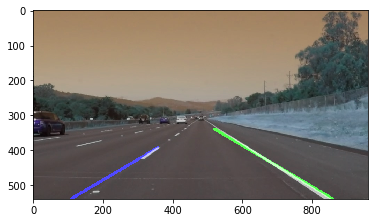

In [14]:

# creating statics images
imageFiles = os.listdir("test_images/")
# static images have no memory
maxHisteresys = 0
for imageName in imageFiles:
    image = cv2.imread('test_images/' + imageName)
    final, bluredImage, maskedImage, withCanny, cropedImage, hough_image = doImageProcess(image)
    cv2.imwrite("test_images_output/" + imageName, final)
    plt.imshow(final)
maxHisteresys = 30
cap = cv2.VideoCapture(videoName)
cv2.namedWindow("Final", 1)
if debug:
    cv2.createTrackbar('lightLimit', 'Final', lightLimit, 255, tracbarRersponse)
    cv2.createTrackbar('slope', 'Final', maxSlope, 1000, tracbarRersponse)
    cv2.createTrackbar('lthres', 'Final', lthres, 255, tracbarRersponse)
    cv2.createTrackbar('mthres', 'Final', mthres, 255, tracbarRersponse)
    cv2.createTrackbar('H', 'Final', midH, 179, tracbarRersponse)
    cv2.createTrackbar('S', 'Final', midS, 255, tracbarRersponse)
    cv2.createTrackbar('V', 'Final', midV, 255, tracbarRersponse)
    cv2.createTrackbar('thr', 'Final', thr, 100, tracbarRersponse)
    cv2.createTrackbar('minL', 'Final', hough_min_length, 100, tracbarRersponse)
    cv2.createTrackbar('maxL', 'Final', hough_max_length, 300, tracbarRersponse)
idx = 0
scrIdx = 0


In [13]:
# start with video processing (or debuging static images)

while (True):
    if videoImages is True:
        if pause is not True:
            ret, image = cap.read()
        if ret == False:
            break 
            cap = cv2.VideoCapture(videoName)
            leftFails = 0
            rightFails = 0
            frames = 0
            continue
    else:
        image = cv2.imread('test_images/' + imageFiles[idx])

    frames += 1
    final, bluredImage, maskedImage, withCanny, cropedImage, hough_image = doImageProcess(image)

    # show debug information
    if debug:
        # update var for tuning.
        updateGlobalVars()

        # Draw debug window with four images
        refreshDebugWindow(maskedImage, cropedImage, hough_image, final)

    else:
        # just show the final image
        cv2.imshow("Final", final)

    # keyboard shortcuts.
    key = cv2.waitKey(1)
    # quit
    if key > 0 and chr(key) == 'q':
        break 
        
    # pause
    if key > 0 and chr(key) == 'p':
        pause = True
        idx += 1
    # continue
    if key > 0 and chr(key) == 'c':
        pause = False
    # save screenshot
    if key > 0 and chr(key) == 's':
        scrIdx += 1
        cv2.imwrite("test_images_output/video" + str(scrIdx) + ".png", final)
    

![example1](./test_images_output/video1.png)
![example2](./test_images_output/video5.png)
![example3](./test_images_output/solidYellowLeft.jpg)
